In [1]:
import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec

import matplotlib.pyplot as plt

## Detailed Process

Currently, we support several models such as  EfficientNet-Lite* models, MobileNetV2, ResNet50 as pre-trained models for image classification. But it is very flexible to add new pre-trained models to this library with just a few lines of code.


The following walks through this end-to-end example step by step to show more detail.

### Step 1: Load Input Data Specific to an On-device ML App

The flower dataset contains 3670 images belonging to 5 classes. Download the archive version of the dataset and untar it.

The dataset has the following directory structure:

<pre>
<b>flower_photos</b>
|__ <b>daisy</b>
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ <b>dandelion</b>
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
|__ <b>roses</b>
    |______ 102501987_3cdb8e5394_n.jpg
    |______ 14982802401_a3dfb22afb.jpg
    |______ ...
|__ <b>sunflowers</b>
    |______ 12471791574_bb1be83df4.jpg
    |______ 15122112402_cafa41934f.jpg
    |______ ...
|__ <b>tulips</b>
    |______ 13976522214_ccec508fe7.jpg
    |______ 14487943607_651e8062a1_m.jpg
    |______ ...
</pre>

In [2]:
image_path = "/Users/egehankarakose/Tez/dataset"

Use `ImageClassifierDataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [3]:
data = ImageClassifierDataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 14325, num_label: 110, labels: Alstonia Scholaris , Arjun, Bael, Basil, Cedrus deodara, Cercis chinensis, Chimonanthus praecox, Chinar , Cinnamomum japonicum, Citrus X sinensis, Cucumis sativus, Gauva, Ginkgo biloba, Indigofera tinctoria, Jamun, Jatropha, Lemon, Magnolia grandiflora, Mango, Mentha, Mespilus germanica, Nerium oleander, Olea europaea, Petroselinum crispum, Phoebe nanmu, Phyllostachys edulis, Podocarpus macrophyllus, Pomegranate, Pongamia Pinnata, Populus canadensis, Prunus persica, Viburnum awabuki, abies_concolor, abies_nordmanniana, acer_campestre, acer_ginnala, acer_griseum, acer_negundo, acer_platanoides, acer_rubrum, acer_saccharinum, acer_saccharum, aesculus_glabra, ailanthus_altissima, albizia_julibrissin, amelanchier_canadensis, betula_alleghaniensis, betula_lenta, betula_nigra, broussonettia_papyrifera, carpinus_caroliniana, carya_cordiformis, carya_glabra, carya_ovata, carya_tomentosa, catalpa_speciosa, cedrus_atlantica, ce

Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [4]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

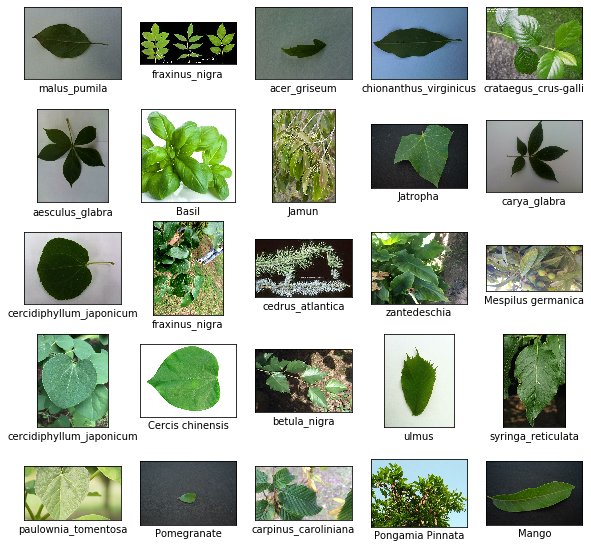

In [5]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.dataset.take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [6]:
model = image_classifier.create(train_data, model_spec=mobilenet_v2_spec, validation_data=validation_data, epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 110)               140910    
Total params: 2,398,894
Trainable params: 140,910
Non-trainable params: 2,257,984
_________________________________________________________________
None
INFO:tensorflow:Retraining the models...
INFO:tensorflow:Retraining the models...
Epoch 1/10
358/358 [==============================] - 2240s 6s/step - loss: 3.0088 - accuracy: 0.4416 - val_loss: 2.3097 - val_accuracy: 0.5973
Epoch 2/10
358/358 [==============================] - 2223s 6s/step - loss: 2.1715 - accuracy: 0.6330 - val_loss: 2.1044 - val_accuracy: 0.

Have a look at the detailed model structure.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 110)               140910    
Total params: 2,398,894
Trainable params: 140,910
Non-trainable params: 2,257,984
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [8]:
loss, accuracy = model.evaluate(test_data)

45/45 [==============================] - 182s 4s/step - loss: 1.9189 - accuracy: 0.7090


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

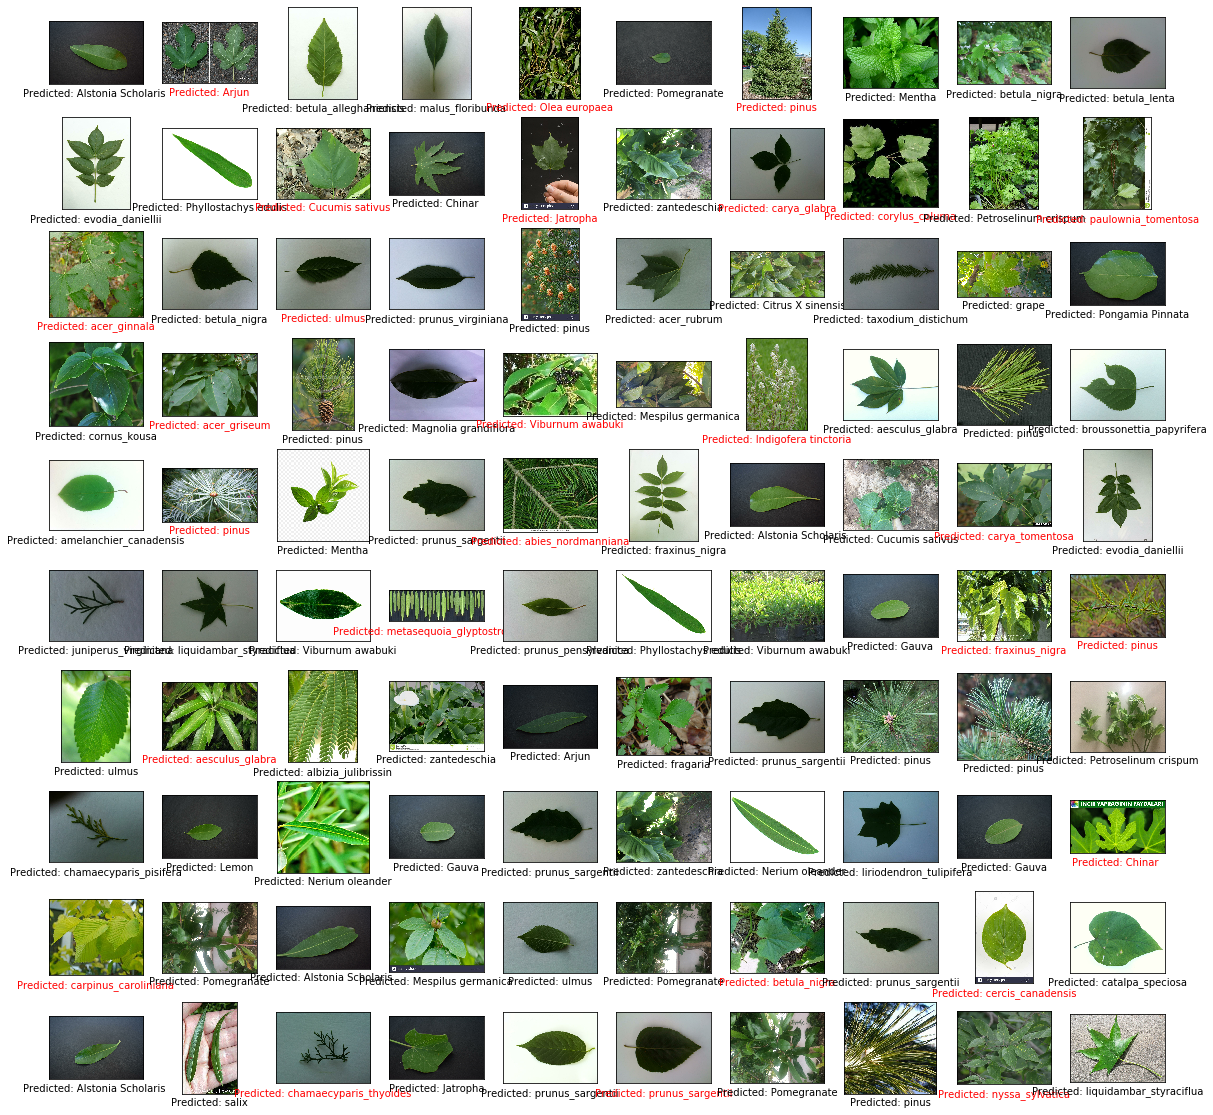

In [9]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Export to TensorFlow Lite Model

Convert the existing model to TensorFlow Lite model format and save the image labels in label file. The default TFLite filename is `model.tflite`, the default label filename is `label.txt`.

In [10]:
model.export(export_dir='.')

INFO:tensorflow:Saving labels in ./labels.txt.
INFO:tensorflow:Saving labels in ./labels.txt.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /var/folders/kz/vzmlqmyx4yx0_vjb7fpx9zlh0000gn/T/tmpm037sck3/assets
INFO:tensorflow:Assets written to: /var/folders/kz/vzmlqmyx4yx0_vjb7fpx9zlh0000gn/T/tmpm037sck3/assets


The TensorFlow Lite model file and label file could be used in [image classification](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification) reference app.

As for android reference app as an example, we could add `flower_classifier.tflite` and `flower_label.txt` in [assets](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android/app/src/main/assets) folder. Meanwhile, change label filename in [code](https://github.com/tensorflow/examples/blob/master/lite/examples/image_classification/android/app/src/main/java/org/tensorflow/lite/examples/classification/tflite/ClassifierFloatMobileNet.java#L65) and TensorFlow Lite file name in [code](https://github.com/tensorflow/examples/blob/master/lite/examples/image_classification/android/app/src/main/java/org/tensorflow/lite/examples/classification/tflite/ClassifierFloatMobileNet.java#L60). Thus, we could run the retrained float TensorFlow Lite model on the android app.


Here, we also demonstrate how to use the above files to run and evaluate the TensorFlow Lite model.

In [11]:
# Read TensorFlow Lite model from TensorFlow Lite file.
with tf.io.gfile.GFile('model.tflite', 'rb') as f:
  model_content = f.read()

# Read label names from label file.
with tf.io.gfile.GFile('labels.txt', 'r') as f:
  label_names = f.read().split('\n')

# Initialze TensorFlow Lite inpterpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

# Run predictions on each test image data and calculate accuracy.
accurate_count = 0
for i, (image, label) in enumerate(test_data.dataset):
    # Pre-processing should remain the same. Currently, just normalize each pixel value and resize image according to the model's specification.
    image, _ = model.preprocess(image, label)
    # Add batch dimension and convert to float32 to match with the model's input
    # data format.
    image = tf.expand_dims(image, 0).numpy()

    # Run inference.
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the label with highest
    # probability.
    predict_label = np.argmax(output()[0])
    # Get label name with label index.
    predict_label_name = label_names[predict_label]

    accurate_count += (predict_label == label.numpy())

accuracy = accurate_count * 1.0 / test_data.size
print('TensorFlow Lite model accuracy = %.4f' % accuracy)

TensorFlow Lite model accuracy = 0.7090


Note that preprocessing for inference should be the same as training. Currently, preprocessing contains normalizing each pixel value and resizing the image according to the model's specification. For  EfficientNet-Lite0, input image should be normalized to `[0, 1]` and resized to `[224, 224, 3]`.